# Overview

This notebook implements an early evaluation of the strength of the theoretical gateway aggregator model using experimental results.
Compares single experimental setups with the Pinciroli's (2023) theoretical results to generate an intuition of their relationship.

It visualizes the results, calculates the _mean average (percentage) error_ between the results, suggesting how 'off' the results are.
It also calculates Pearson's $r$ to understand the correlation between results.


In [29]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

import datetime
import json
import os
import typing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import gssi_experiment.util.util as util
import gssi_experiment.util.notebook_helper as nb_helper
import gssi_experiment.util.stat_helper as stat_helper

pincirollis_data_path = (
    "/workspaces/muBench-experiment/gssi_experiment/gateway_offloading/multi_N25.csv"
)
synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

base_path = "/workspaces/muBench-experiment/gssi_experiment/gateway_offloading/results/pinciroli_replication_2/"

## Dataframe creation


In [30]:
import gssi_experiment.util.prometheus_raw_data_helper as prom_data_helper


TIME_FORMAT = "%Y-%m-%dT%H:%M:%S.000Z"
TIMEFORMAT_2 = "%Y-%m-%d %H:%M:%S"

service_cols = ["gw", "s1", "s2", "s3"]


def get_data_points() -> typing.Iterator:
    for experiment_folder in util.iterate_through_nested_folders(
        base_path, max_depth=3
    ):
        # Calculates delay data
        mubench_file = f"{experiment_folder}/mubench_results.csv"
        exp_df = pd.read_csv(mubench_file, header=0)
        avg_latency = np.average(exp_df["latency_ms"])

        # Reads metadata to calculate s3 intensity
        meta_path = f"{experiment_folder}/metadata.json"
        with open(meta_path, "r", encoding="utf-8") as meta_file:
            metadata = json.loads(meta_file.read())
        cpu_limit = metadata["cmd_arguments"]["cpu_limit"]
        replicas = metadata["cmd_arguments"]["replicas"]
        max_steps = metadata["cmd_arguments"]["simulation_steps"]
        # HACK: add this to the metadata.
        step = int(os.path.basename(os.path.dirname(experiment_folder)).split("_")[0])
        offload = int(os.path.basename(experiment_folder).split("_")[0])
        dashboard_intensity = step / max_steps

        # Calculates CPU utilization data.
        start_time = datetime.datetime.strptime(metadata["start_time"], TIME_FORMAT)
        end_time = datetime.datetime.strptime(metadata["end_time"], TIME_FORMAT)
        utilization_data = prom_data_helper.calculate_average_cpu_time(
            experiment_folder, service_cols, start_time, end_time
        )

        data_point = [
            step,
            max_steps,
            dashboard_intensity,
            avg_latency,
            cpu_limit,
            replicas,
            metadata['start_time'],
            metadata['end_time'],
            offload,
            *utilization_data,
        ]
        yield data_point


cols = [
    "step",
    "max_step",
    "dashboard_intensity",
    "avg_latency_ms",
    "cpu_limit",
    "replicas",
    "experiment_start_time",
    "experiment_end_time",
    "offload",
]
cpu_util_format = "cpu_utilization_{service}"
cpu_columns = [cpu_util_format.format(service=service) for service in service_cols]
cols.extend(cpu_columns)

data_points = get_data_points()

df = pd.DataFrame(data_points, columns=cols)

old_df_len = len(df)
df = df.dropna()
new_df_len = len(df)
if new_df_len != old_df_len:
    print("!!!SOME ROWS WERE REMOVED BECAUSE THEY ARE NAN!!!")
    print(f"The row count was {old_df_len} and now is {new_df_len}.")

df

Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw', 's1', 's2.1', 's3']
Retrying to calculate averages with services: ['gw', 's1.1', 's2.1', 's3.1']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw.2', 's1', 's2', 's3']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw.2', 's1', 's2', 's3']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw.2', 's1', 's2', 's3']
Updating initial services to: ['gw', 's1.1', 's2', 's3']
Retrying to calculate averages with services: ['gw', 's1.1', 's2.1', 's3']
Updating initial services to: ['gw.1', 's1', 's2', 's3']


,step,max_step,dashboard_intensity,avg_latency_ms,cpu_limit,replicas,experiment_start_time,experiment_end_time,offload,cpu_utilization_gw,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3
0,0,5,0.0,655.366719,1000m,1,2023-11-25T21:35:11.000Z,2023-11-25T21:46:48.000Z,10,0.762082,0.001880,0.925597,0.392791
1,0,5,0.0,643.414706,1000m,1,2023-11-25T22:48:14.000Z,2023-11-25T22:59:51.000Z,5,0.470338,0.003570,0.929309,0.691832
2,1,5,0.2,569.512742,1000m,1,2023-11-25T21:59:29.000Z,2023-11-25T22:11:06.000Z,10,0.893941,0.276308,0.803400,0.341187
3,1,5,0.2,524.677684,1000m,1,2023-11-25T23:12:33.000Z,2023-11-25T23:24:11.000Z,5,0.587233,0.303180,0.902849,0.673232
4,2,5,0.4,443.481461,1000m,1,2023-11-25T23:49:00.000Z,2023-11-26T00:00:37.000Z,0,0.233082,0.761707,0.771761,0.898119
5,2,5,0.4,561.621645,1000m,1,2023-11-25T21:23:02.000Z,2023-11-25T21:34:39.000Z,10,0.909828,0.563638,0.599558,0.258411
6,2,5,0.4,399.857718,1000m,1,2023-11-25T22:36:05.000Z,2023-11-25T22:47:43.000Z,5,0.767465,0.850664,0.896163,0.685492
7,3,5,0.6,576.830563,1000m,1,2023-11-25T22:11:37.000Z,2023-11-25T22:23:25.000Z,10,0.878055,0.885335,0.377775,0.164589
8,3,5,0.6,561.176014,1000m,1,2023-11-25T23:24:42.000Z,2023-11-25T23:36:20.000Z,5,0.537309,0.918448,0.398398,0.311344
9,4,5,0.8,740.292267,1000m,1,2023-11-25T21:47:19.000Z,2023-11-25T21:58:57.000Z,10,0.658598,0.913452,0.150557,0.066104


In [31]:
synth_cpu_cols = ["N_A", "r_gw", "R0", "Us1", "Us2", "Us3", "Ugw"]
pinc_df = synth_df[synth_cpu_cols]

# Calculates offload to merge with.
pinc_df["offload"] = pinc_df["r_gw"].transform(lambda x: int(1 / x))
pinc_df = pinc_df.drop("r_gw", axis=1)

# Calculates s3 intensity to merge with.
pinc_df.loc[:, "dashboard_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on=["dashboard_intensity", "offload"])

df

/tmp/ipykernel_24545/1908269031.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df["offload"] = pinc_df["r_gw"].transform(lambda x: int(1 / x))


,step,max_step,dashboard_intensity,avg_latency_ms,cpu_limit,replicas,experiment_start_time,experiment_end_time,offload,cpu_utilization_gw,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,R0,Us1,Us2,Us3,Ugw
0,0,5,0.0,655.366719,1000m,1,2023-11-25T21:35:11.000Z,2023-11-25T21:46:48.000Z,10,0.762082,0.001880,0.925597,0.392791,253.088133,0.000000,0.200001,0.494500,9.999953e-01
1,0,5,0.0,651.272870,1000m,1,2023-11-26T03:28:02.000Z,2023-11-26T03:39:40.000Z,10,0.788896,0.004454,0.905281,0.385247,253.088133,0.000000,0.200001,0.494500,9.999953e-01
2,0,5,0.0,647.823122,1000m,1,2023-11-26T05:29:31.000Z,2023-11-26T05:41:08.000Z,10,0.759433,0.004323,0.896269,0.382340,253.088133,0.000000,0.200001,0.494500,9.999953e-01
3,0,5,0.0,643.414706,1000m,1,2023-11-25T22:48:14.000Z,2023-11-25T22:59:51.000Z,5,0.470338,0.003570,0.929309,0.691832,251.205326,0.000000,0.697776,0.994375,4.944017e-01
4,0,5,0.0,660.553826,1000m,1,2023-11-26T01:01:54.000Z,2023-11-26T01:13:42.000Z,5,0.471035,0.001904,0.898254,0.669691,251.205326,0.000000,0.697776,0.994375,4.944017e-01
5,0,5,0.0,648.819868,1000m,1,2023-11-26T06:42:23.000Z,2023-11-26T06:54:00.000Z,5,0.461839,0.003300,0.907562,0.689856,251.205326,0.000000,0.697776,0.994375,4.944017e-01
6,1,5,0.2,569.512742,1000m,1,2023-11-25T21:59:29.000Z,2023-11-25T22:11:06.000Z,10,0.893941,0.276308,0.803400,0.341187,249.890258,0.199297,0.158619,0.398522,9.998901e-01
7,1,5,0.2,564.638623,1000m,1,2023-11-26T03:40:11.000Z,2023-11-26T03:51:48.000Z,10,0.921138,0.287685,0.827803,0.352917,249.890258,0.199297,0.158619,0.398522,9.998901e-01
8,1,5,0.2,565.642501,1000m,1,2023-11-26T04:40:56.000Z,2023-11-26T04:52:33.000Z,10,0.903575,0.285127,0.801811,0.343164,249.890258,0.199297,0.158619,0.398522,9.998901e-01
9,1,5,0.2,524.677684,1000m,1,2023-11-25T23:12:33.000Z,2023-11-25T23:24:11.000Z,5,0.587233,0.303180,0.902849,0.673232,188.547683,0.543589,0.677662,0.973801,6.592242e-01


# Request Delay


## Visualization


averaged_columns=['avg_latency_ms', 'cpu_utilization_gw', 'cpu_utilization_s1', 'cpu_utilization_s2', 'cpu_utilization_s3', 'N_A', 'r_gw', 'R0', 'Us1', 'Us2', 'Us3', 'Ugw']


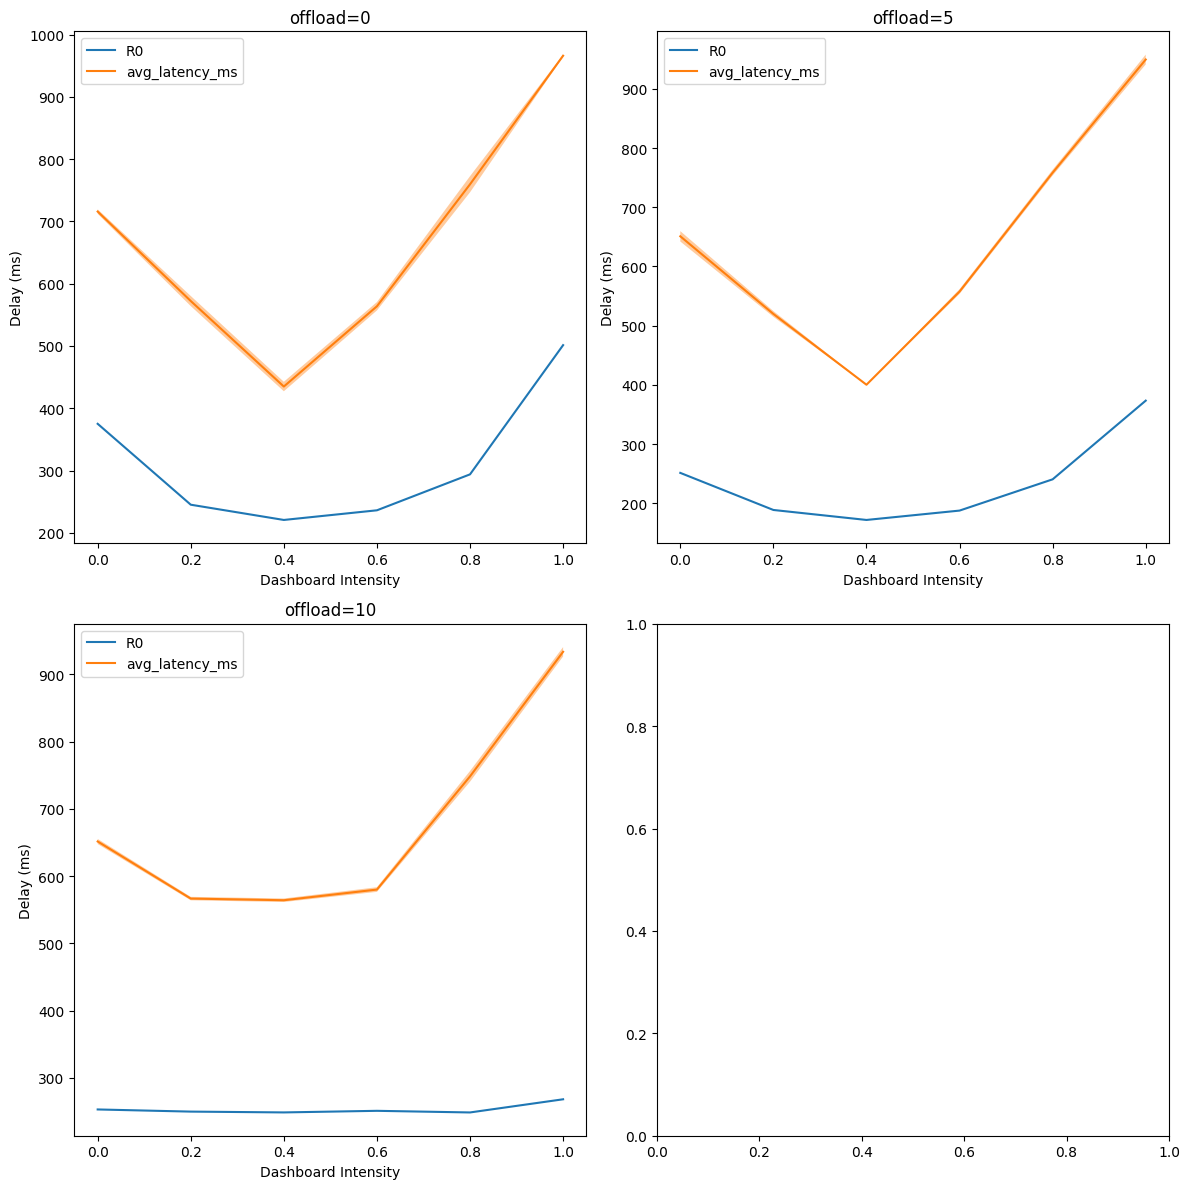

In [32]:
averaged_columns = ["avg_latency_ms", *cpu_columns, *synth_cpu_cols]
group_columns = ["dashboard_intensity", "offload"]
avg_df = nb_helper.to_averaged_df(df, group_columns, averaged_columns)

nb_helper.create_multi_figure(
    avg_df, ["R0", "avg_latency_ms"], "dashboard_intensity", "offload", "Delay (ms)"
)

averaged_columns=['avg_latency_ms', 'cpu_utilization_gw', 'cpu_utilization_s1', 'cpu_utilization_s2', 'cpu_utilization_s3', 'N_A', 'r_gw', 'R0', 'Us1', 'Us2', 'Us3', 'Ugw']


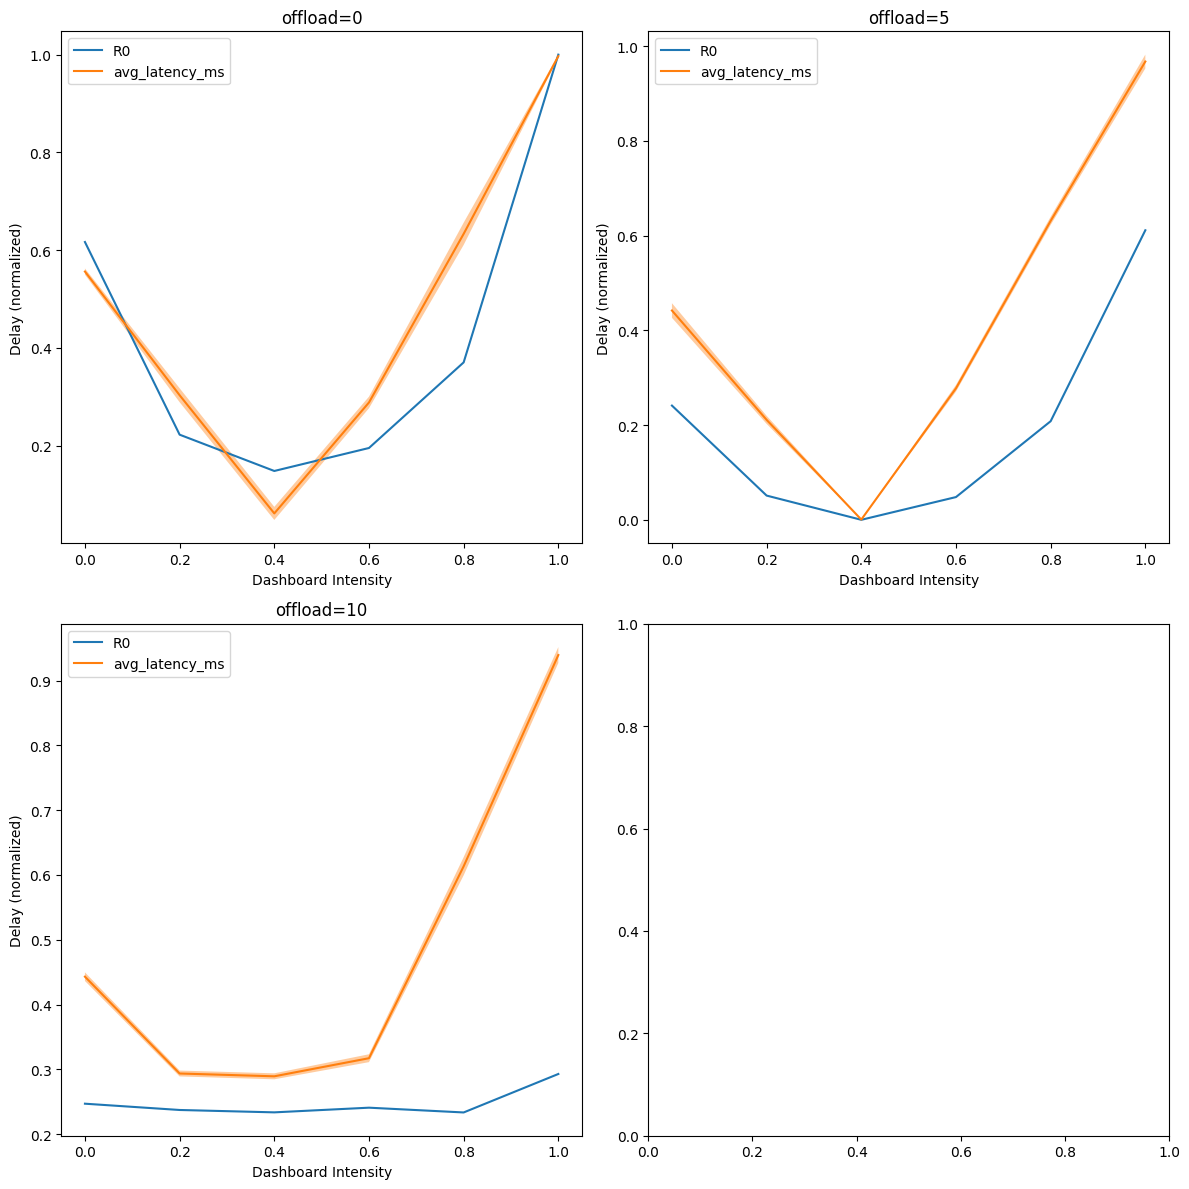

In [33]:
# Normalized data

def normalize(x, x_min, x_max):
    x -= x_min
    x /= x_max - x_min
    return x


df_norm = pd.DataFrame()
df_norm["dashboard_intensity"] = df["dashboard_intensity"]
df_norm["offload"] = df["offload"]

r0_min, r0_max = min(df["R0"]), max(df["R0"])
df_norm["R0"] = df["R0"].transform(lambda x: normalize(x, r0_min, r0_max))

lat_min, lat_max = min(df["avg_latency_ms"]), max(df["avg_latency_ms"])
df_norm["avg_latency_ms"] = df["avg_latency_ms"].transform(
    lambda x: normalize(x, lat_min, lat_max)
)

avg_norm_df = nb_helper.to_averaged_df(df_norm, group_columns, averaged_columns)
avg_norm_df
nb_helper.create_multi_figure(
    avg_norm_df,
    ["R0", "avg_latency_ms"],
    "dashboard_intensity",
    "offload",
    "Delay (normalized)",
)

## Evaluation


### Compares the delay data set using MAPE and Spearman's r


### Mean average percentage error

Intuitively, how off the result is on average.

$\displaystyle M = \frac{1}{n}\sum^n_{t=1} \bigg|\frac{A_t - F_t}{A_t}\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [34]:

absolute_mape = stat_helper.mape(df["R0"], df["avg_latency_ms"])
eps = 1
normalized_mape = stat_helper.mape(df_norm["R0"] + eps, df_norm["avg_latency_ms"] + eps)

print(f"{absolute_mape=:.2f}%, {normalized_mape=:.2f}% ({eps=})")

absolute_mape=59.27%, normalized_mape=11.99% (eps=1)


### Mean absolute error

$\displaystyle M = \frac{1}{n}\sum^n_{t=1}\bigg|A_t - F_t\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [35]:


absolute_mae = stat_helper.mae(df["R0"], df["avg_latency_ms"])
normalized_mae = stat_helper.mae(df_norm["R0"], df_norm["avg_latency_ms"])

print(f"{absolute_mae=:.3f}, {normalized_mae=:.2f}%")

absolute_mae=393.829, normalized_mae=0.19%


# Visualizing the relationship


averaged_columns=['avg_latency_ms', 'cpu_utilization_gw', 'cpu_utilization_s1', 'cpu_utilization_s2', 'cpu_utilization_s3', 'N_A', 'r_gw', 'R0', 'Us1', 'Us2', 'Us3', 'Ugw']


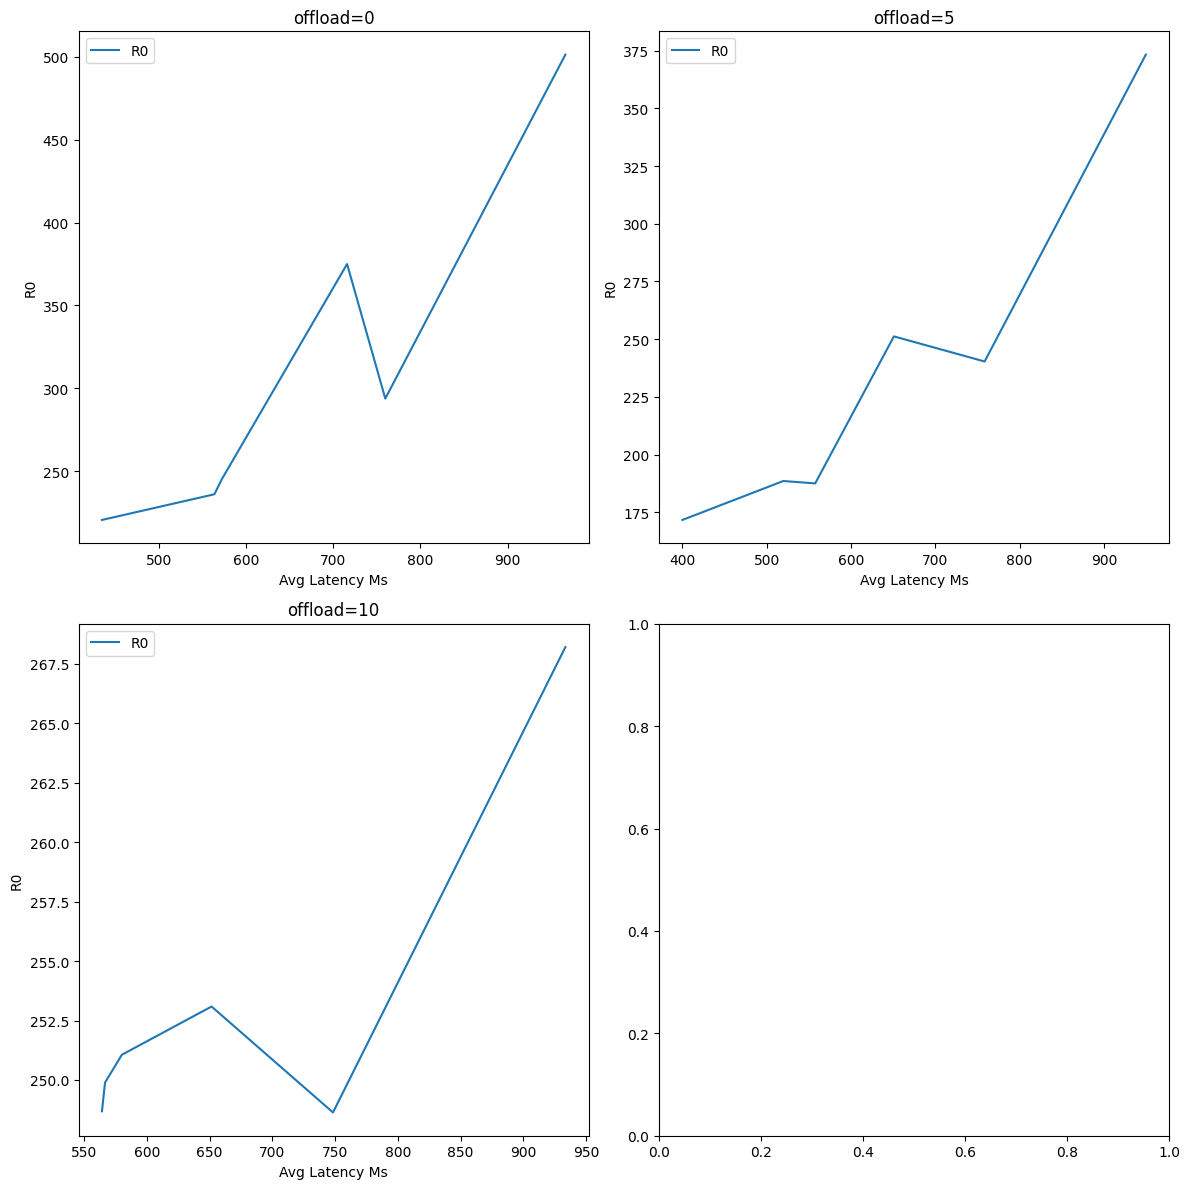

In [36]:
avg_df = nb_helper.to_averaged_df(df, group_columns, averaged_columns)
nb_helper.create_multi_figure(avg_df, ["R0"], "avg_latency_ms", "offload", y_label="R0")

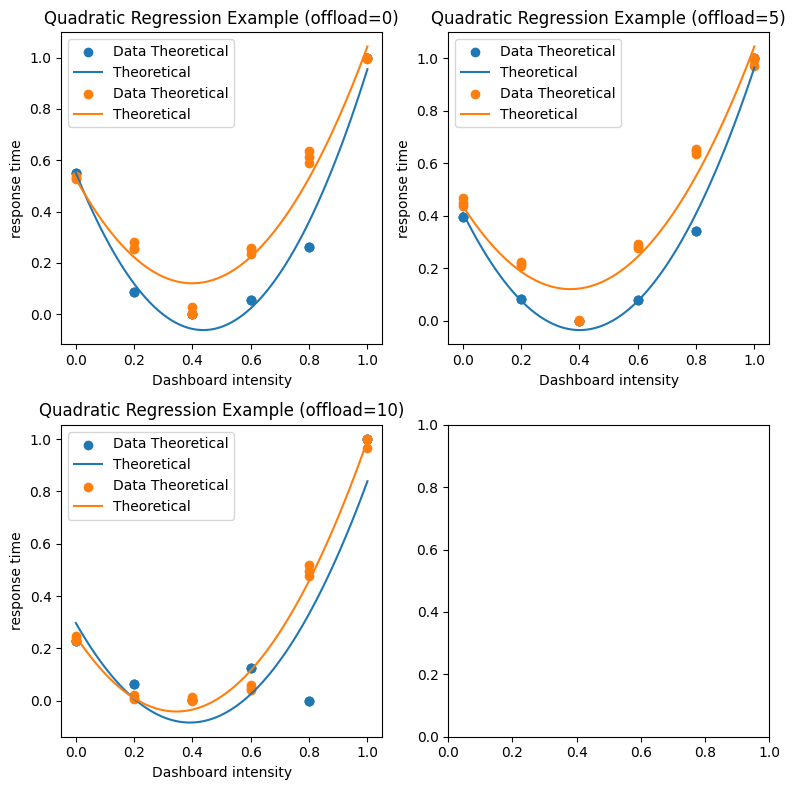

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math

def normalize_field(df: pd.DataFrame, field: str) -> pd.DataFrame:
    min_x, max_x = min(df[field]), max(df[field])
    df.loc[:, field] = df[field].transform(lambda x: normalize(x, min_x, max_x))
    return df


def make_model(x, y):
    # Fit a quadratic regression model
    coefficients = np.polyfit(x, y, 2)
    quadratic_model = np.poly1d(coefficients)

    # Generate y values from the model for smooth plotting
    x_smooth = np.linspace(min(x), max(x), 100)
    y_smooth = quadratic_model(x_smooth)
    return x_smooth, y_smooth


def visualize_plots(df: pd.DataFrame, y_keys: str, split_key: str):
    splits = df[split_key].unique()
    splits.sort()
    num_subplots = len(splits)

    num_rows = math.ceil(num_subplots / 2)
    num_cols = 2
    _, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, split in enumerate(splits):
        tmp_df = df[df[split_key] == split]
        ax = axes[i]

        tmp_df = normalize_field(tmp_df, "R0")
        tmp_df = normalize_field(tmp_df, "avg_latency_ms")

        x = tmp_df["dashboard_intensity"].tolist()

        for y_key in y_keys:
            y = tmp_df[y_key].tolist()
            x_smooth, y_smooth = make_model(x, y)

            ax.scatter(x, y, label="Data Theoretical")
            ax.plot(x_smooth, y_smooth, label="Theoretical")
            ax.set_xlabel("Dashboard intensity")
            ax.set_ylabel("response time")
            ax.set_title(f"Quadratic Regression Example ({split_key}={split})")
            ax.legend()

    plt.tight_layout()
    plt.show()


visualize_plots(df, ["R0", "avg_latency_ms"], "offload")

# CPU Utilization


## Visualization


averaged_columns=['avg_latency_ms', 'cpu_utilization_gw', 'cpu_utilization_s1', 'cpu_utilization_s2', 'cpu_utilization_s3', 'N_A', 'r_gw', 'R0', 'Us1', 'Us2', 'Us3', 'Ugw']


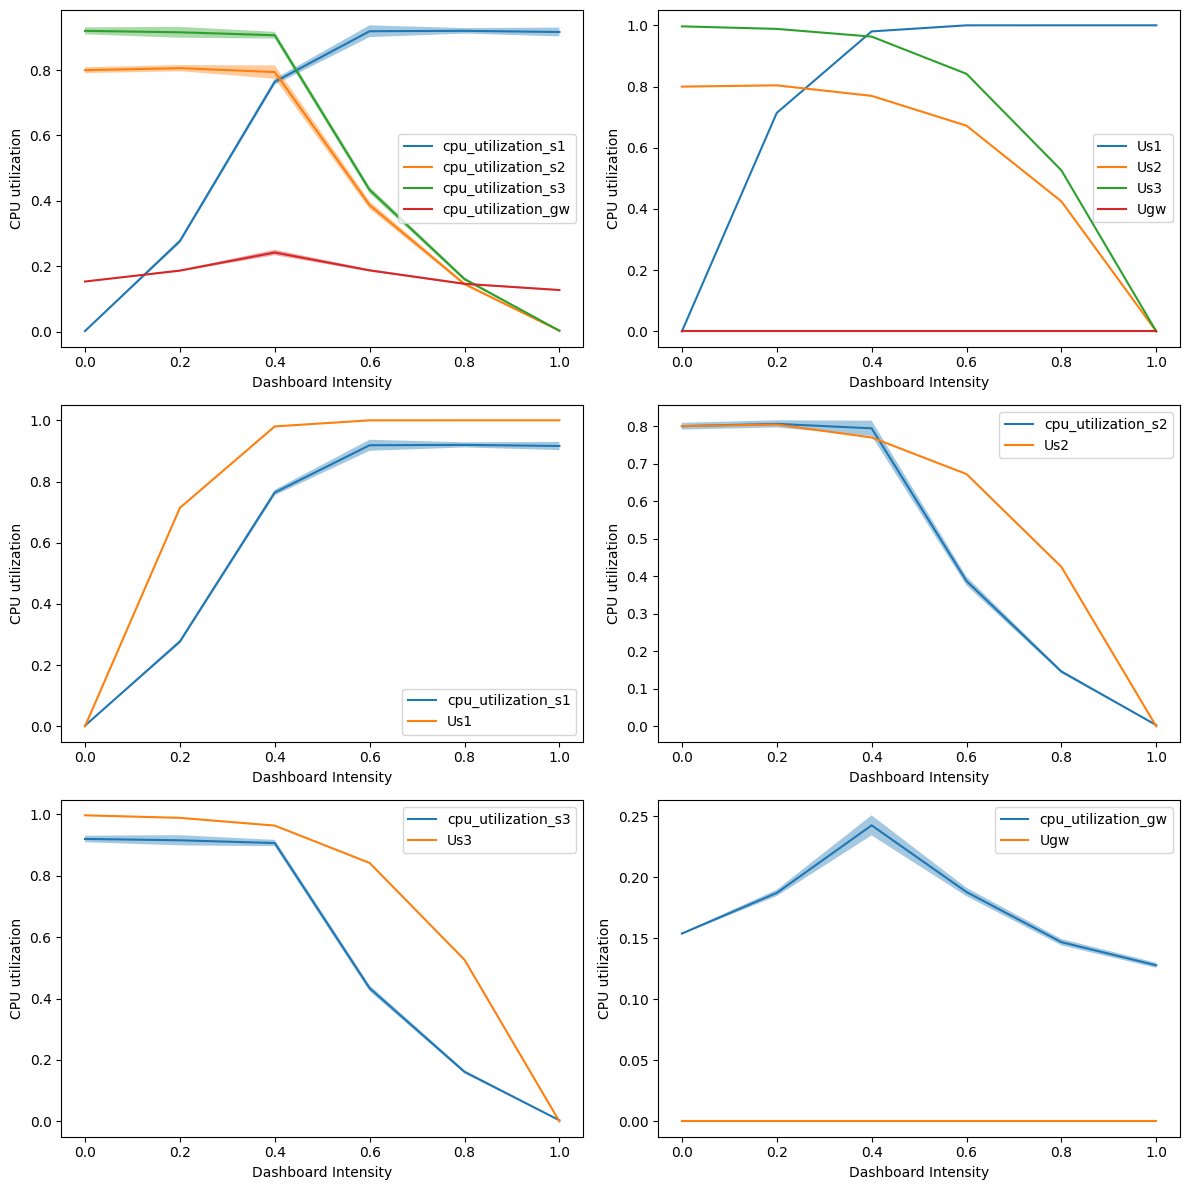

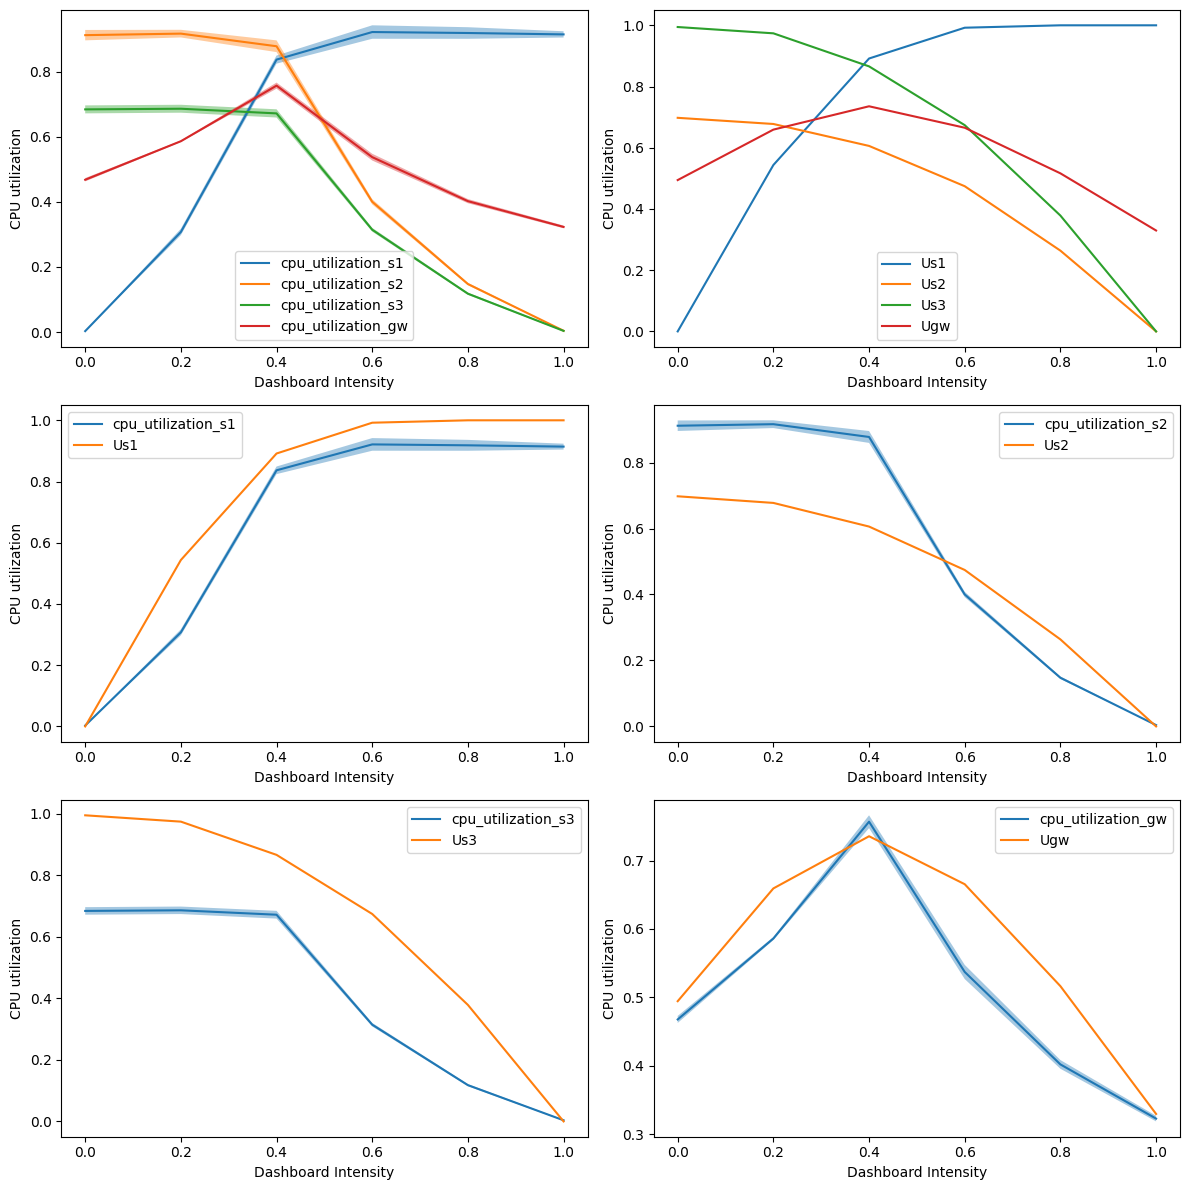

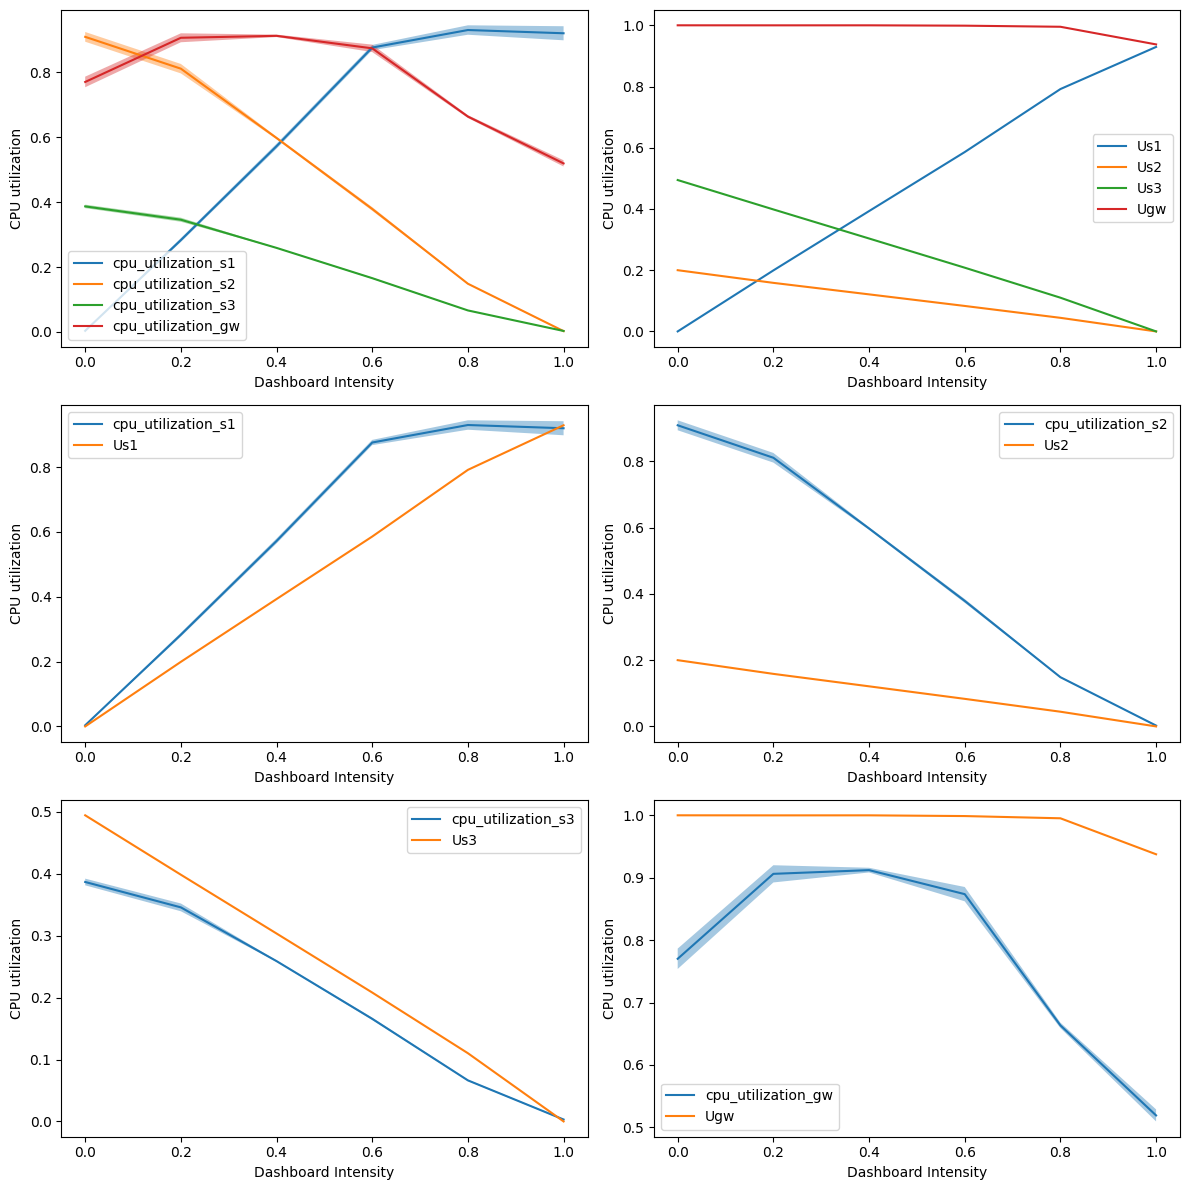

In [38]:
from typing import List, Tuple


comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_gw",
    ),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gw", "Ugw"),
]

split_key = "offload"
splits = df[split_key].unique()
splits.sort()

avg_df = nb_helper.to_averaged_df(df, group_columns, averaged_columns)

for split in splits:
    sub_df = avg_df[avg_df[split_key] == split]
    sub_df = sub_df.sort_values("dashboard_intensity")
    nb_helper.create_plot_comparisons(comparison_tuples, sub_df, 'dashboard_intensity')

averaged_columns=['avg_latency_ms', 'cpu_utilization_gw', 'cpu_utilization_s1', 'cpu_utilization_s2', 'cpu_utilization_s3', 'N_A', 'r_gw', 'R0', 'Us1', 'Us2', 'Us3', 'Ugw']


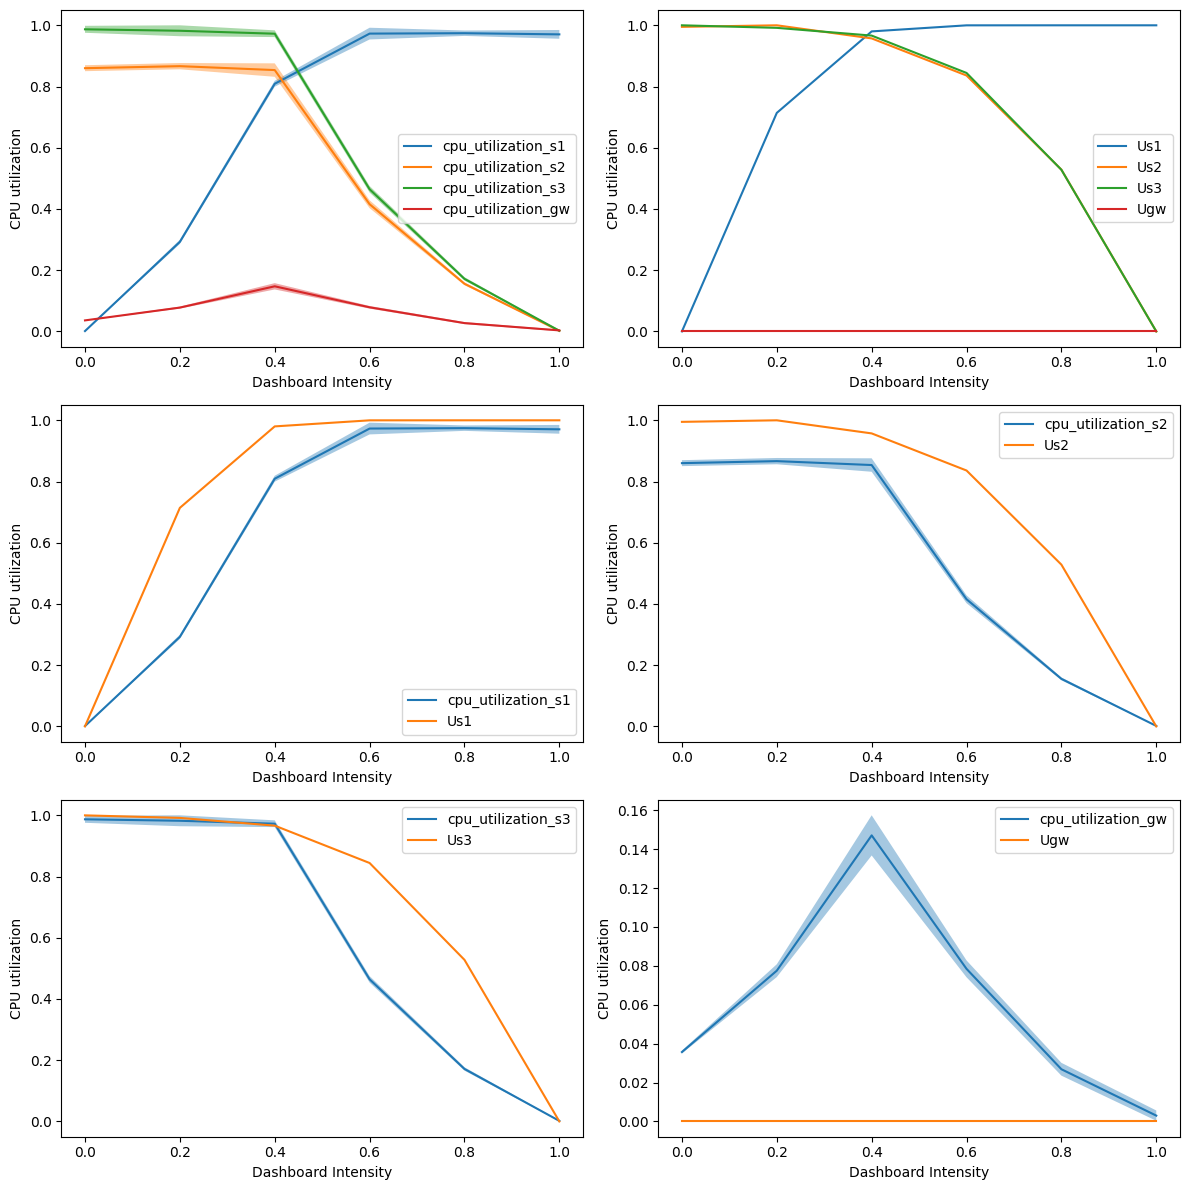

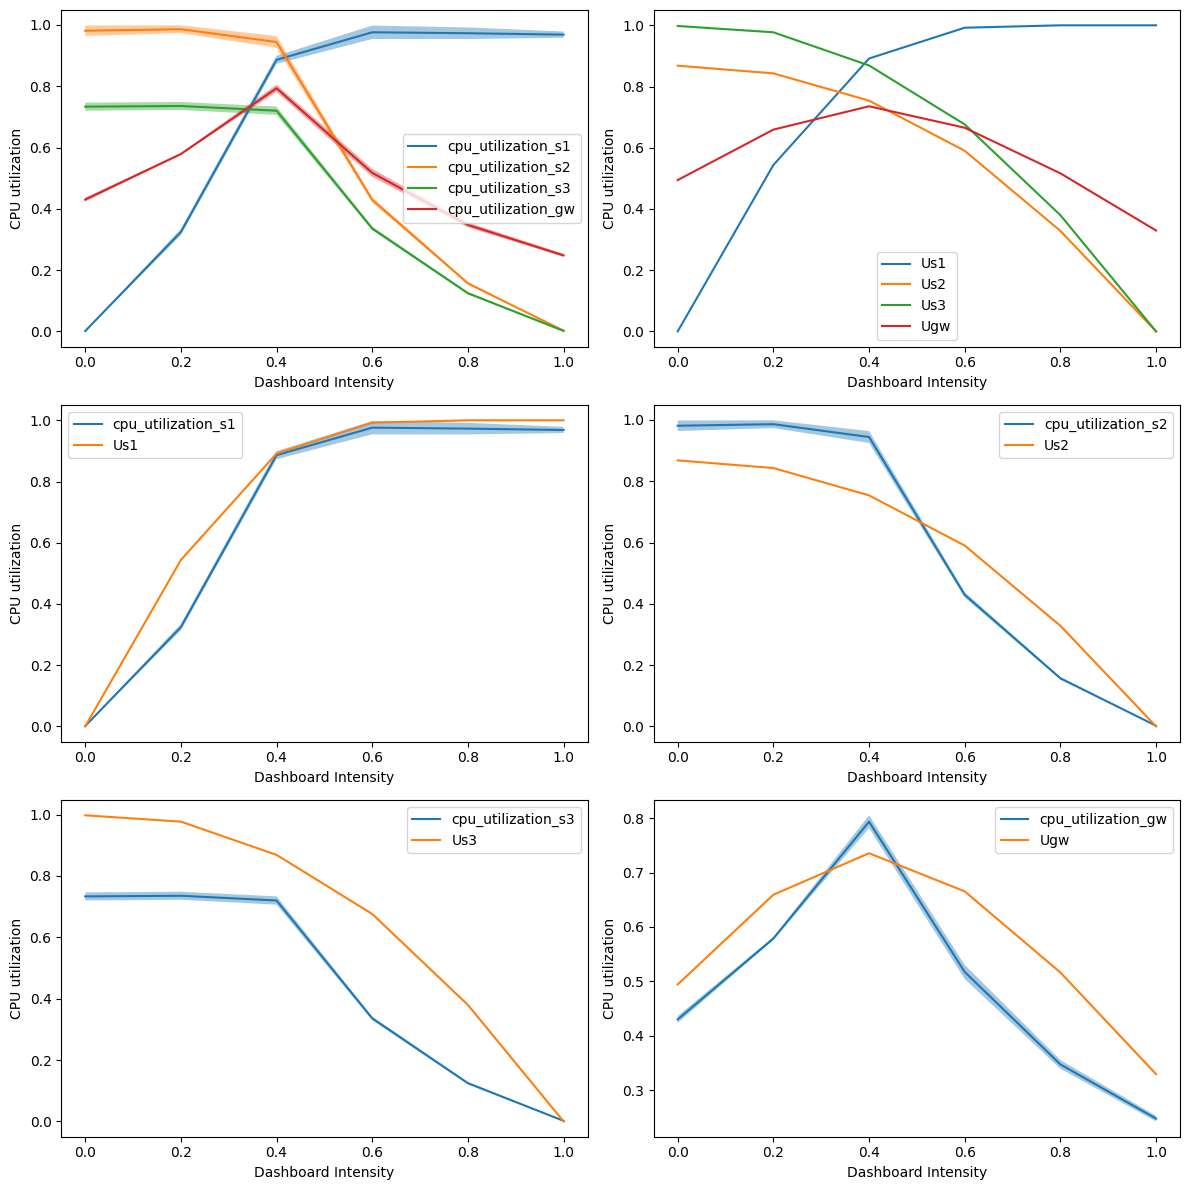

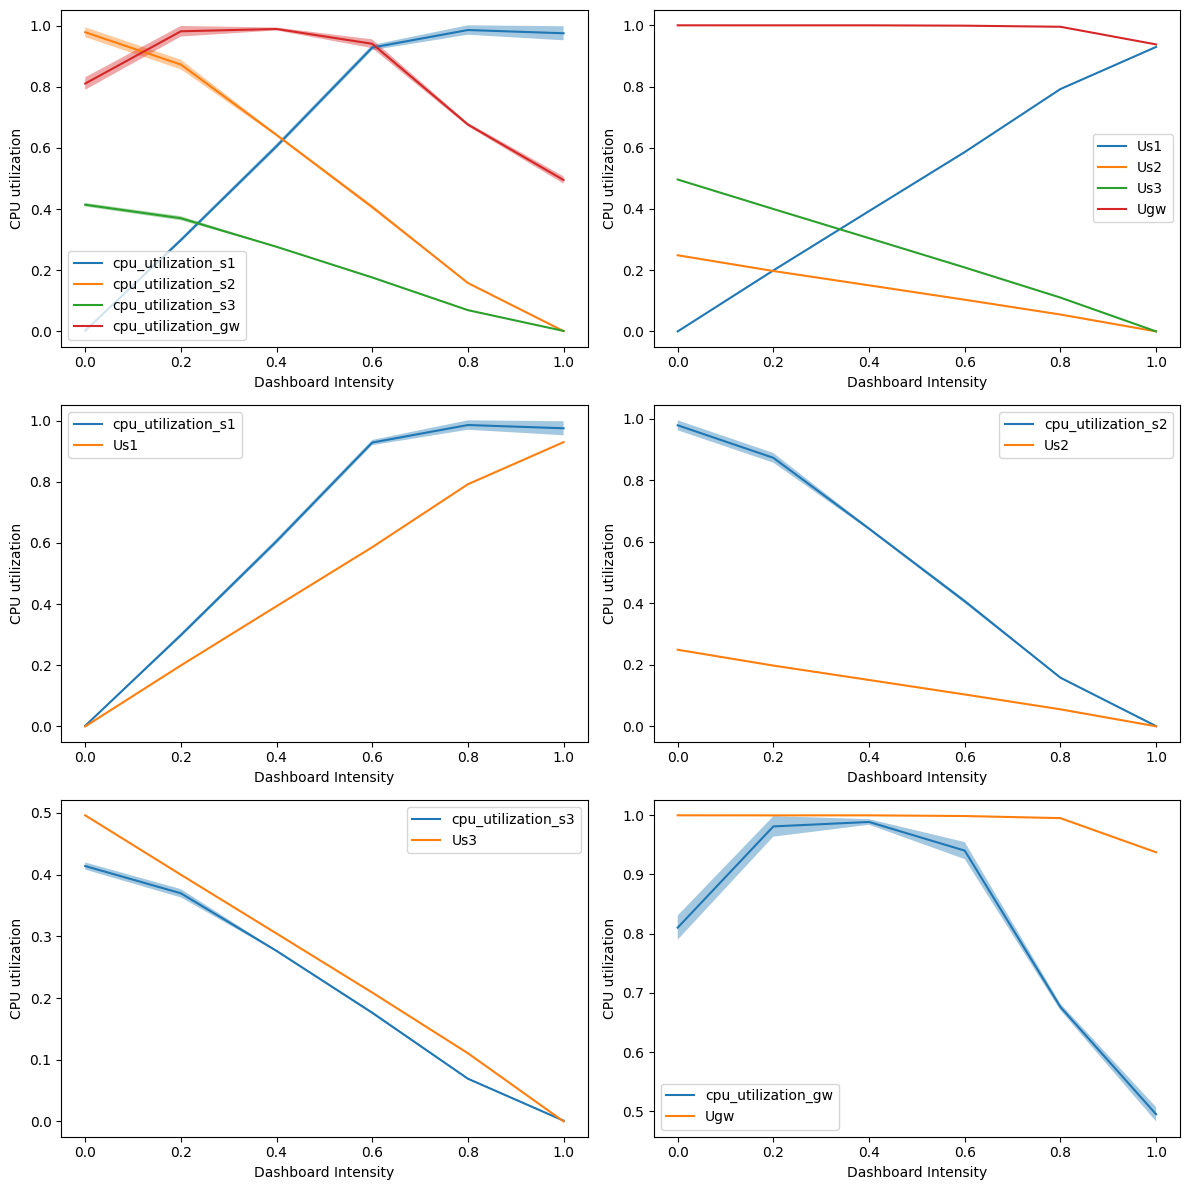

In [39]:
norm_df = pd.DataFrame()

for col in df.select_dtypes(include="number").columns:
    min_x, max_x = min(df[col]), max(df[col])
    norm_df[col] = df[col].transform(lambda x: normalize(x, min_x, max_x))


comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_gw",
    ),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gw", "Ugw"),
]


split_key = "offload"
splits = df[split_key].unique()
splits.sort()

sub_df = df.copy()
for key in set(util.flatten(comparison_tuples)):
    sub_df = normalize_field(sub_df, key)
avg_sub_df = nb_helper.to_averaged_df(sub_df, group_columns, averaged_columns)

for split in splits:
    sub_df = avg_sub_df[avg_sub_df[split_key] == split]
    sub_df = sub_df.sort_values("dashboard_intensity")
    nb_helper.create_plot_comparisons(comparison_tuples, sub_df, "dashboard_intensity")

## Evaluation


In [40]:
comparison_tuples = [
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gw", "Ugw"),
]

### Spearman's correlation coefficient


In [41]:
split_key = "offload"
splits = df[split_key].unique()
splits.sort()

print("Spearman's correlation coefficient:")

for split in splits:
    print(f"{split_key}={split}")
    sub_df = df[df[split_key] == split]

    for real, expected in comparison_tuples:
        correlation_coefficient, p_value = spearmanr(sub_df[expected], sub_df[real])

        sig = "significant" if p_value < 0.05 else "insignificant"
        # Display the result
        print(f"{real}: {correlation_coefficient:.3f} ({p_value=:.3f} = {sig})")
    print()

Spearman's correlation coefficient:
offload=0
cpu_utilization_s1: 0.887 (p_value=0.000 = significant)
cpu_utilization_s2: 0.906 (p_value=0.000 = significant)
cpu_utilization_s3: 0.931 (p_value=0.000 = significant)
cpu_utilization_gw: 0.041 (p_value=0.872 = insignificant)

offload=5
cpu_utilization_s1: 0.862 (p_value=0.000 = significant)
cpu_utilization_s2: 0.956 (p_value=0.000 = significant)
cpu_utilization_s3: 0.937 (p_value=0.000 = significant)
cpu_utilization_gw: 0.875 (p_value=0.000 = significant)

offload=10
cpu_utilization_s1: 0.956 (p_value=0.000 = significant)
cpu_utilization_s2: 0.988 (p_value=0.000 = significant)
cpu_utilization_s3: 0.988 (p_value=0.000 = significant)
cpu_utilization_gw: 0.630 (p_value=0.005 = significant)



### Mean average (percentage) error


In [42]:
split_key = "offload"
splits = df[split_key].unique()
splits.sort()

for split in splits:
    print()
    print(f"{split=}")
    sub_df = df[df[split_key] == split]
    sub_norm_df = norm_df[norm_df[split_key] == split]

    for real, expected in comparison_tuples:
        mape_score = stat_helper.mape(sub_df[expected], sub_df[real])
        mae_score = stat_helper.mae(sub_df[expected], sub_df[real])
        print(f"{real}: {mape_score=:.2f}%, {mae_score=:.3f}")

        eps = 1
        # norm_mape_score = mape(sub_norm_df[expected] + eps, sub_norm_df[real] + eps)
        try:
            norm_mae_score = 100 * stat_helper.mae(sub_norm_df[expected], sub_norm_df[real])
            print(f"{real}: ({eps=}), {norm_mae_score=:.2f}%")
        except:
            pass

    print()


split=0
cpu_utilization_s1: mape_score=52.12%, mae_score=0.150
cpu_utilization_s1: (eps=1), norm_mae_score=11.25%
cpu_utilization_s2: mape_score=61.57%, mae_score=0.101
cpu_utilization_s2: (eps=1), norm_mae_score=19.45%
cpu_utilization_s3: mape_score=73.84%, mae_score=0.164
cpu_utilization_s3: (eps=1), norm_mae_score=12.90%
cpu_utilization_gw: mape_score=100.00%, mae_score=0.174
cpu_utilization_gw: (eps=1), norm_mae_score=6.14%


split=5
cpu_utilization_s1: mape_score=34.94%, mae_score=0.089
cpu_utilization_s2: mape_score=46.32%, mae_score=0.153
cpu_utilization_s3: mape_score=92.05%, mae_score=0.236
cpu_utilization_gw: mape_score=12.58%, mae_score=0.062


split=10
cpu_utilization_s1: mape_score=35.15%, mae_score=0.119
cpu_utilization_s2: mape_score=81.05%, mae_score=0.373
cpu_utilization_s3: mape_score=42.04%, mae_score=0.049
cpu_utilization_gw: mape_score=32.47%, mae_score=0.214

